**Stacked LSTM Time series model**

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies

Multiple hidden LSTM layers can be stacked one on top of another in what is referred to as a Stacked LSTM model.

**Importing required libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from joblib import dump

**Reading the dataset**

In [ ]:
df = pd.read_csv("/content/drive/My Drive/ibmhc/Wind_Turbine_Scada_Dataset.csv")

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
df

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913


Since this is a time series analysis, I need only the date and the respective date's generated power

In [ ]:
df1 = pd.DataFrame({"Date":df['Date/Time'],"Power":df['LV ActivePower (kW)']})

In [ ]:
df1.head()

,Date,Power
0,01 01 2018 00:00,380.047791
1,01 01 2018 00:10,453.769196
2,01 01 2018 00:20,306.376587
3,01 01 2018 00:30,419.645905
4,01 01 2018 00:40,380.650696


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    50530 non-null  object 
 1   Power   50530 non-null  float64
dtypes: float64(1), object(1)
memory usage: 789.7+ KB


In [ ]:
df1.describe()

,Power
count,50530.000000
mean,1307.684332
std,1312.459242
min,-2.471405
25%,50.677890
50%,825.838074
75%,2482.507568
max,3618.732910


In [ ]:
df1['Date']=pd.to_datetime(df1['Date'])

In [ ]:
df1.set_index('Date',inplace=True)

In [ ]:
df1.head()

,Power
Date,
2018-01-01 00:00:00,380.047791
2018-01-01 00:10:00,453.769196
2018-01-01 00:20:00,306.376587
2018-01-01 00:30:00,419.645905
2018-01-01 00:40:00,380.650696


**Visualizing The Data**

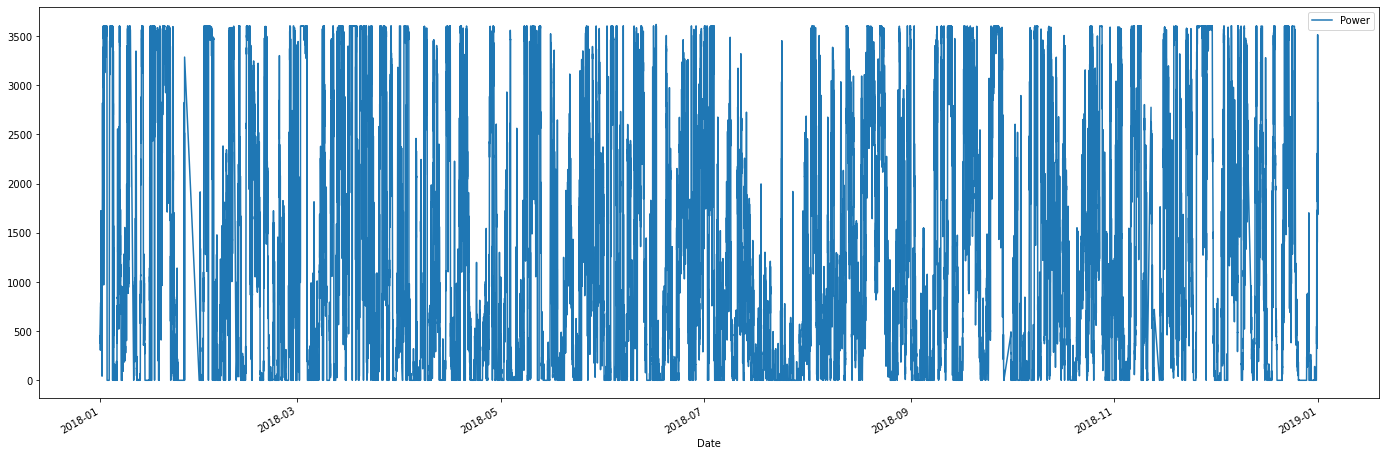

In [ ]:
df1.plot(figsize=(24,8))

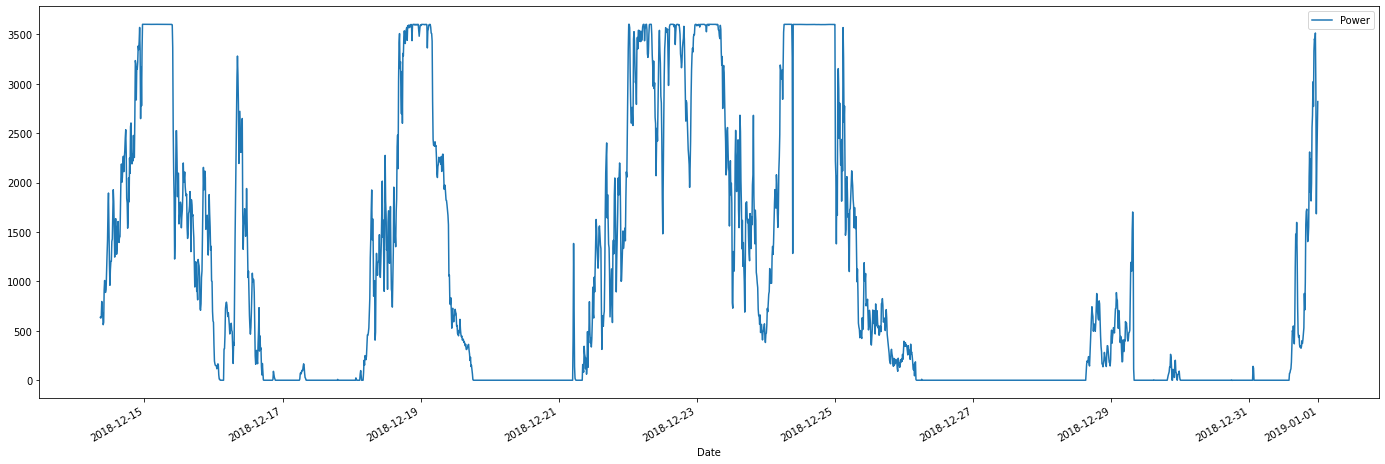

In [ ]:
df1.iloc[48000:].plot(figsize=(24,8))

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
df1

array([[0.10563314],
       [0.1259914 ],
       [0.08528875],
       ...,
       [0.60852085],
       [0.69539448],
       [0.77955763]])

**splitting the dataset into train and test set**

In [ ]:
training_size=int(len(df1)*0.80)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:

training_size,test_size

(40424, 10106)

In [ ]:
train_data

array([[0.10563314],
       [0.1259914 ],
       [0.08528875],
       ...,
       [0.00068248],
       [0.00068248],
       [0.00068248]])

In [ ]:
test_data

array([[6.82481521e-04],
       [6.82481521e-04],
       [6.82481521e-04],
       ...,
       [6.08520853e-01],
       [6.95394481e-01],
       [7.79557634e-01]])

**Convert an array of values into a dataset matrix**

In [ ]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1): ###i=0, 0,1,2,3-----143      144
		a = dataset[i:(i+time_step), 0]    
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
time_step = 144
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(40279, 144)
(40279,)


(None, None)

In [ ]:
X_train

array([[1.05633144e-01, 1.25991400e-01, 8.52887507e-02, ...,
        9.32408415e-01, 9.31260459e-01, 9.32942244e-01],
       [1.25991400e-01, 8.52887507e-02, 1.16568211e-01, ...,
        9.31260459e-01, 9.32942244e-01, 9.33424633e-01],
       [8.52887507e-02, 1.16568211e-01, 1.05799637e-01, ...,
        9.32942244e-01, 9.33424633e-01, 9.32533546e-01],
       ...,
       [1.94832938e-01, 2.63020210e-01, 3.23531982e-01, ...,
        6.82481521e-04, 6.82481521e-04, 6.82481521e-04],
       [2.63020210e-01, 3.23531982e-01, 3.81595001e-01, ...,
        6.82481521e-04, 6.82481521e-04, 6.82481521e-04],
       [3.23531982e-01, 3.81595001e-01, 2.92879736e-01, ...,
        6.82481521e-04, 6.82481521e-04, 6.82481521e-04]])

In [ ]:
y_train

array([9.33424633e-01, 9.32533546e-01, 9.39895174e-01, ...,
       6.82481521e-04, 6.82481521e-04, 6.82481521e-04])

In [ ]:
print(X_test.shape), print(ytest.shape)

(9961, 144)
(9961,)


(None, None)

**reshape input to be [samples, time steps, features] which is required for LSTM**

In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

**Create the Stacked LSTM model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(144,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 144, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 144, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
630/630 [==============================] - 15s 23ms/step - loss: 0.0145 - val_loss: 0.0049
Epoch 2/100
630/630 [==============================] - 14s 22ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 3/100
630/630 [==============================] - 14s 22ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 4/100
630/630 [==============================] - 14s 22ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 5/100
630/630 [==============================] - 14s 22ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 6/100
630/630 [==============================] - 14s 22ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 7/100
630/630 [==============================] - 14s 22ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 8/100
630/630 [==============================] - 14s 22ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 9/100
630/630 [==============================] - 14s 22ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 10/100
630/630 [==============================] - 14s 22ms/step - l

**Lets Do the prediction and check performance metrics**

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

**Transform back to original form**

In [ ]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

**Calculate RMSE performance metrics**

In [ ]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

1786.4790236977183

**Test Data RMSE**

In [ ]:
math.sqrt(mean_squared_error(ytest,test_predict))

1964.6899411529841

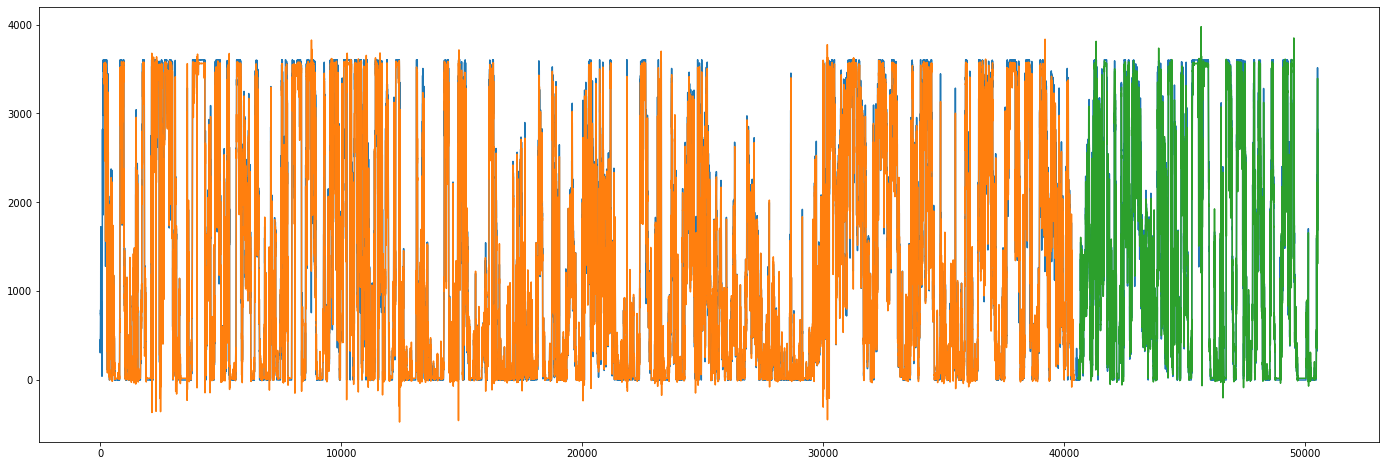

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=144
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.figure(figsize=(24,8))
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)

10106

In [ ]:
x_input=test_data[9961:].reshape(1,-1)
x_input.shape

(1, 145)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
temp_input

[0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.039445414384975654,
 0.03459045415979427,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152309,
 0.0006824815211152

In [ ]:
len(temp_input)

145

**demonstrate prediction for next ........**

In [ ]:
from numpy import array

lst_output=[]
n_steps=144
i=0
while(i<72):
    
    if(len(temp_input)>144):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, 144, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [6.82481521e-04 6.82481521e-04 6.82481521e-04 6.82481521e-04
 6.82481521e-04 6.82481521e-04 6.82481521e-04 6.82481521e-04
 3.94454144e-02 3.45904542e-02 6.82481521e-04 6.82481521e-04
 6.82481521e-04 6.82481521e-04 6.82481521e-04 6.82481521e-04
 6.82481521e-04 6.82481521e-04 6.82481521e-04 6.82481521e-04
 6.82481521e-04 6.82481521e-04 6.82481521e-04 6.82481521e-04
 6.82481521e-04 6.82481521e-04 6.82481521e-04 6.82481521e-04
 6.82481521e-04 6.82481521e-04 6.82481521e-04 6.82481521e-04
 6.82481521e-04 6.82481521e-04 6.82481521e-04 6.82481521e-04
 6.82481521e-04 6.82481521e-04 6.82481521e-04 6.82481521e-04
 6.82481521e-04 6.82481521e-04 6.82481521e-04 6.82481521e-04
 6.82481521e-04 6.82481521e-04 6.82481521e-04 6.82481521e-04
 6.82481521e-04 6.82481521e-04 6.82481521e-04 6.82481521e-04
 6.82481521e-04 6.82481521e-04 6.82481521e-04 6.82481521e-04
 6.82481521e-04 6.82481521e-04 6.82481521e-04 6.82481521e-04
 6.82481521e-04 6.82481521e-04 6.82481521e-04 6.82481521e-04
 6.82481521e

In [ ]:
day_new=np.arange(1,145)
day_pred=np.arange(145,217)

In [ ]:
len(df1)

50530

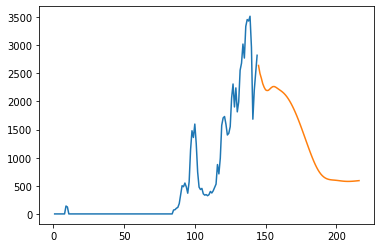

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[50386:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [ ]:
len(df3)

50602

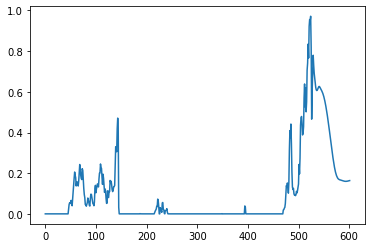

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[50000:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

In [ ]:
print(df3)

[[380.047790527343], [453.76919555664], [306.376586914062], [419.645904541015], [380.650695800781], [402.391998291015], [447.605712890625], [387.2421875], [463.65121459960903], [439.725708007812], [498.181701660156], [526.816223144531], [710.587280273437], [655.194274902343], [754.7625122070309], [790.173278808593], [742.985290527343], [748.229614257812], [736.647827148437], [787.246215820312], [722.8640747070309], [935.0333862304681], [1220.60900878906], [1053.77197265625], [1493.8079833984302], [1724.4880371093698], [1636.93505859375], [1385.4880371093698], [1098.93200683593], [1021.4580078125001], [1164.89294433593], [1073.33203125], [1165.30798339843], [1177.98999023437], [1170.53601074218], [1145.53601074218], [1114.02697753906], [1153.18505859375], [1125.3310546875], [1228.73205566406], [1021.7930297851499], [957.378173828125], [909.887817382812], [1000.95397949218], [1024.47802734375], [1009.53399658203], [899.4929809570309], [725.110107421875], [585.2593994140619], [443.9139099

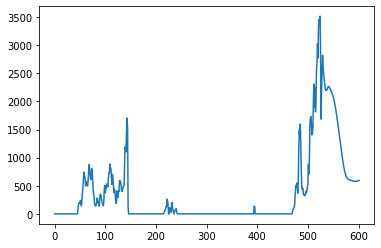

In [ ]:
plt.plot(df3[50000:])